In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import widgets

In [2]:
# etapa exploratoria
#df = pd.read_csv("data/2020-03-23_1930.csv", sep=";", decimal = ",")
#df.tail()

## Por provincia

### Cargo manualmente los casos nuevos cada día en una planilla ``ods`` (libreoffice) que exporto al csv de acá abajo:

In [3]:
prov = pd.read_csv("data/totales_x_provincia_toViz.csv", sep=";")
prov.loc[prov["provincia"]=="Ciudad de Buenos Aires","provincia"]="CABA"
prov.loc[prov["provincia"]=="Buenos Aires","provincia"]="Bs As"
prov.loc[prov["provincia"]=="Santiago Del Estero","provincia"]="S del Estero"
prov.loc[prov["provincia"]=="Tierra Del Fuego","provincia"]="T del Fuego"
prov.tail(20)

fecha     provincia  casos_diarios
715  2020-04-06         Chaco              4
716  2020-04-06          CABA             17
717  2020-04-06       Córdoba              7
718  2020-04-06    Corrientes              2
719  2020-04-06    Entre Ríos              0
720  2020-04-06         Jujuy              0
721  2020-04-06      La Pampa              0
722  2020-04-06       Mendoza              1
723  2020-04-06      Misiones              0
724  2020-04-06       Neuquén              6
725  2020-04-06     Río Negro              2
726  2020-04-06         Salta              0
727  2020-04-06      San Luis              1
728  2020-04-06    Santa Cruz              0
729  2020-04-06      Santa Fe              8
730  2020-04-06  S del Estero              6
731  2020-04-06   T del Fuego              2
732  2020-04-06       Tucumán              5
733  2020-04-06      San Juan              0
734  2020-04-06      La Rioja              1

In [4]:
last_date = prov.iloc[len(prov)-1,0]
last_date = f"{last_date.split('-')[2]}/{last_date.split('-')[1]}/{last_date.split('-')[0]}"

### Creo nueva columna con los casos acumulados

In [5]:
lista_prov = list(prov["provincia"].unique())

In [6]:
prov["casos_acum"] = ""

In [7]:
for provincia in lista_prov:
    ind = prov["provincia"] == provincia
    acum = prov[ind]["casos_diarios"].cumsum()
    prov.loc[ind,"casos_acum"] = acum

In [8]:
prov.tail(20)

fecha     provincia  casos_diarios  casos_acum
715  2020-04-06         Chaco              4         118
716  2020-04-06          CABA             17         453
717  2020-04-06       Córdoba              7         149
718  2020-04-06    Corrientes              2          25
719  2020-04-06    Entre Ríos              0          20
720  2020-04-06         Jujuy              0           5
721  2020-04-06      La Pampa              0           3
722  2020-04-06       Mendoza              1          30
723  2020-04-06      Misiones              0           3
724  2020-04-06       Neuquén              6          51
725  2020-04-06     Río Negro              2          18
726  2020-04-06         Salta              0           3
727  2020-04-06      San Luis              1          10
728  2020-04-06    Santa Cruz              0          22
729  2020-04-06      Santa Fe              8         183
730  2020-04-06  S del Estero              6          10
731  2020-04-06   T del Fuego              2          78
732  2020-04-06       Tucumán              5          27
733  2020-04-06      San Juan              0           1
734  2020-04-06      La Rioja              1           9

### Chequeo casos totales hasta la fecha

In [9]:
prov["casos_diarios"].sum()

1628

### Armo un dict con fecha y totales diarios y acumulados
Se puede mejorar y hacerlo todo con pandas, pero ya lo hice

In [10]:
fechas = list(prov["fecha"].unique())
total_diario = {"fecha":[], "total":[], "acum":[]}
acum = 0
for fecha in fechas:
    ind = prov["fecha"] == fecha
    total_diario["fecha"].append(fecha) 
    total_diario["total"].append(prov[ind]["casos_diarios"].sum())
    acum += total_diario["total"][-1]
    total_diario["acum"].append(acum)

In [11]:
#total_diario

### Gráficos barras animado

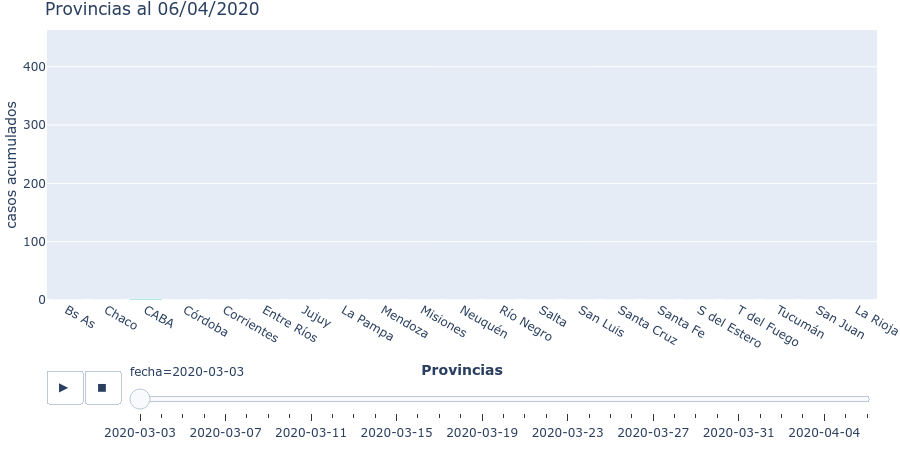

In [12]:
max_acum = prov["casos_acum"].max()
fig = px.bar(prov, x="provincia", y="casos_acum",color="provincia",
             animation_frame="fecha", animation_group="provincia", range_y=[0, max_acum+10],
             labels={'provincia':'<b>Provincias</b>', 'casos_acum':'casos acumulados'}, height=450, width=660)
fig.update_layout(title_text=f'Provincias al {last_date}')
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.update_layout(showlegend=False)
fig.show(config={'displayModeBar': True})

In [13]:
fig.write_html("graphs/barras_provincias_anim.html", include_plotlyjs="cdn", full_html=False)

## Totales argentina y diarios

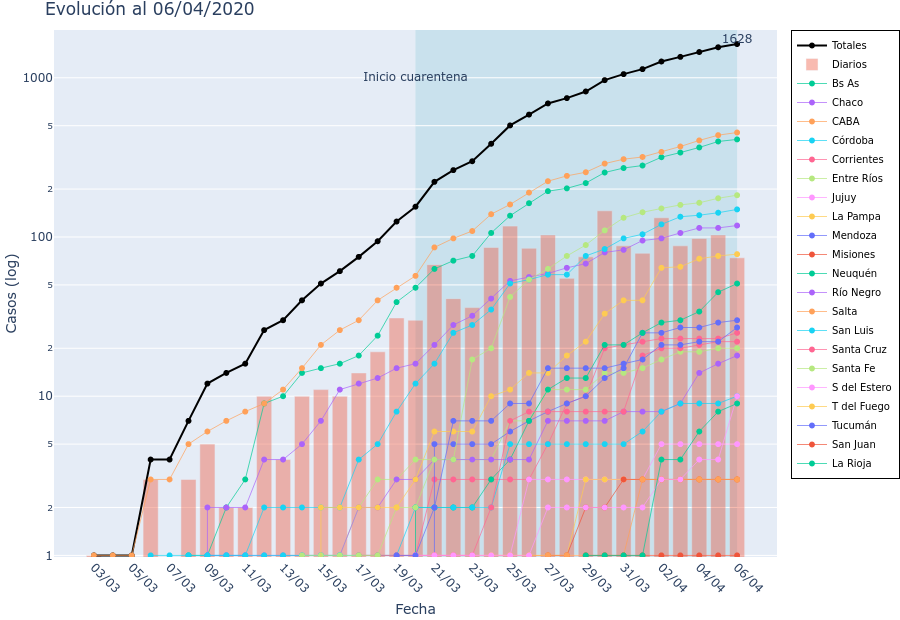

In [14]:
fig = go.Figure()
fechas = list(prov["fecha"].unique())

fig.add_trace(go.Scatter(x = total_diario["fecha"], y=total_diario["acum"], mode='lines+markers',  line=dict(width=2, color="black"), name="Totales",text=total_diario["acum"]))
fig.add_trace(go.Bar(x = total_diario["fecha"], y=total_diario["total"], name="Diarios",opacity=0.4, text=total_diario["total"]))

nom_provincias = {"Ciudad de Buenos Aires":"CABA", "Santiago Del Estero": "S. del Estero", "Tierra Del Fuego":"T. del Fuego", "Buenos Aires":"Bs As"}
for provincia in lista_prov:
    ind = prov["provincia"] == provincia
    #dia = list(range(1,len(ind)))
    fig.add_trace(go.Scatter(x = prov.loc[ind,"fecha"], y=prov.loc[ind,"casos_acum"], text=nom_provincias.get(provincia, provincia), mode='lines+markers', #x = dia
                             line=dict(width=0.7),
                             name=nom_provincias.get(provincia, provincia),))
fig.add_trace(go.Scatter(
    x=["2020-03-20",],
    y=[1000,],
    text=["Inicio cuarentena",],
    mode="text",
    showlegend=False,
))

# última cantidad total
ultimo_val = total_diario["acum"][-1]
fig.add_trace(go.Scatter(
    x=[fecha,],
    y=[ultimo_val+100,],
    text=[ultimo_val,],
    mode="text",
    showlegend=False,
))

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            # x-reference is assigned to the x-values
            xref="x",
            # y-reference is assigned to the plot paper [0,1]
            yref="paper",
            x0="2020-03-20",
            y0=0,
            x1="2020-04-06",
            y1=1,
            fillcolor="LightBlue",
            opacity=0.5,
            layer="below",
            line_width=0,
        ),
    ]
)    

fig.update_layout(yaxis_range=(-0.01, 3.3), 
                  title_text=f'Evolución al {last_date}', 
                  height=620, yaxis_title="Casos (log)",
                  yaxis_type="log",
                  #xaxis_type="log",
                 )
fig.update_layout(width=750,margin={"r":0,"t":30,"l":0,"b":0},
    legend=dict(
        #x=0.02,
        #y=1.15,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=10,
            color="black"
        ),
        #bgcolor="LightSteelBlue",
        bordercolor="Black",
        borderwidth=1,
        orientation="v",
    ),
    xaxis=go.layout.XAxis(
        tickvals=fechas[slice(0,len(fechas),2)],
        tickangle=45,
        tickformat = '%d/%m',
        title="Fecha",
    )
)


fig.show(config={'scrollZoom': True, 'displayModeBar': True,})

In [15]:
fig.write_html("graphs/total_arg_provincias.html", include_plotlyjs="cdn", full_html=False)

## Agrego widget para seleccionar log

In [13]:
log = widgets.Dropdown(
    options=["log", "lineal"],
    value="lineal",
    description='Escala eje y: ',
)

In [14]:
trazas_provincias = list()

for provincia in lista_prov:
    ind = prov["provincia"] == provincia
    trazas_provincias.append(go.Scatter(x = prov.loc[ind,"fecha"], y=prov.loc[ind,"casos_acum"],
                             hoverinfo='y',
                             mode='lines+markers',
                             line=dict(width=0.5),
                             stackgroup='one', # define stack group
                             name=provincia,)
                             )

trazas_provincias.append(go.Scatter(x = prov.loc[ind,"fecha"], y=DPenazzi,  line=dict(width=2, dash='dash', color='royalblue'), 
                             name="Aprox. DPenazzi"))


g = go.FigureWidget(data=trazas_provincias)

g.layout.xaxis.title = 'Fecha'
g.layout.yaxis.title = 'Casos'
g.layout.title = 'Evolución de casos en de covid-19 por Provincia al 28/03/2020'

In [15]:
def escala(change):
    with g.batch_update():
        if log.value == "log":
            g.layout.yaxis.type = 'log'
        else:
            g.layout.yaxis.type = 'linear'

log.observe(escala, names="value")

In [16]:
container = widgets.HBox([log])
widgets.VBox([container,g])

<module 'ipywidgets.widgets.widget_output' from '/home/emiliano/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget_output.py'>

## Abandonados a su suerte

Acá dejo lo que fui haciendo y finalmente descarté

### Gráfico área apilado por provincias

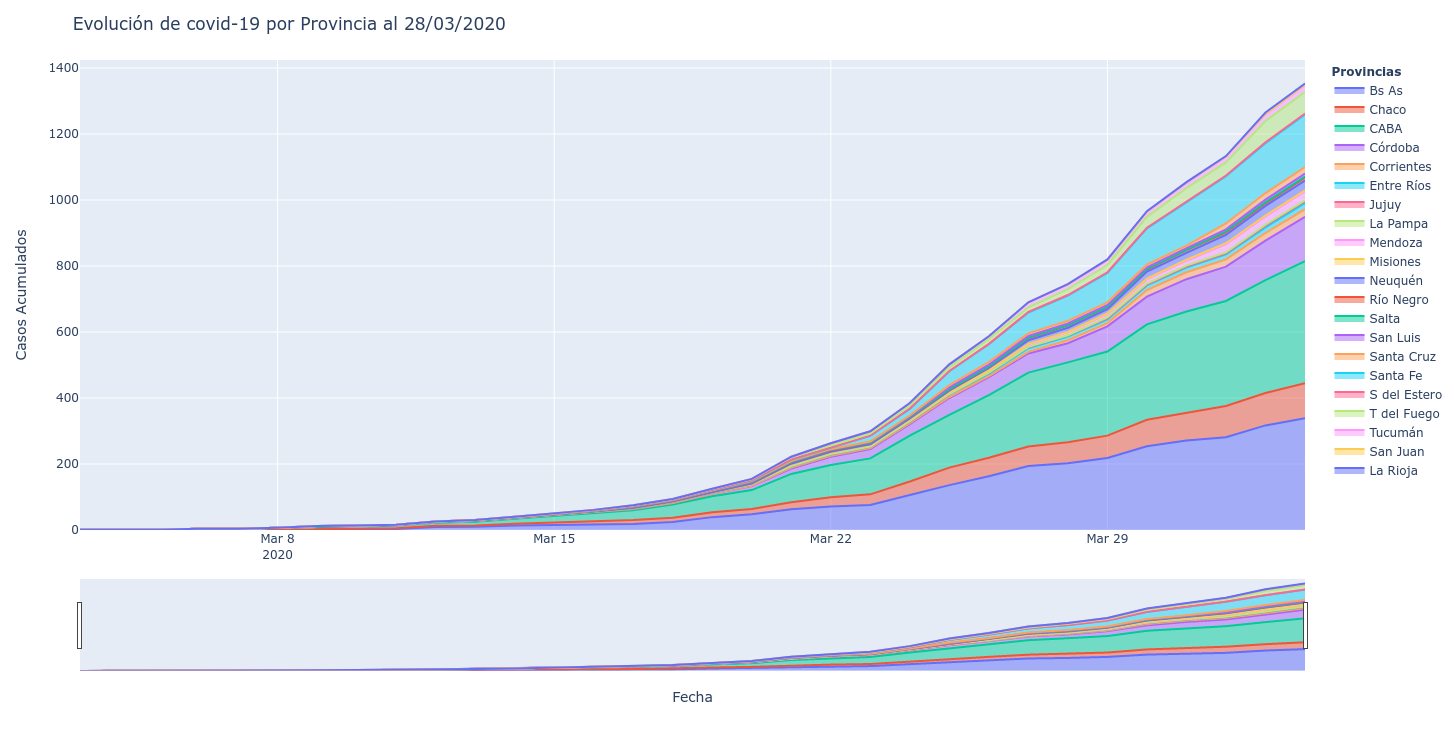

In [58]:
fig = px.area(prov, x="fecha", y="casos_acum", color="provincia", height=750,
             labels={'provincia':'<b>Provincias</b>', 'casos_acum':'Casos Acumulados', "fecha":"Fecha"})
fig.update_layout(title_text='Evolución de covid-19 por Provincia al 28/03/2020',#yaxis_type="log",
                 xaxis_rangeslider_visible=True)
fig.show()

## Agrego aproximación de Daniel Penazzi

Para agregar curvas no puedo usar plotly express, tengo que usar graph objects y es un bardo, pero mas o menos salió:

- https://twitter.com/DPenazzi/status/1239215593385078786?s=20

$$f(t) = (3.3327)*(1.2405)^t, t\ge1$$

In [61]:
t = np.array(range(1,28))
DPenazzi=(3.3327)*(1.2405)**t

In [62]:
DPenazzi

array([   4.13421435,    5.1284929 ,    6.36189544,    7.8919313 ,
          9.78994078,   12.14442153,   15.06515491,   18.68832467,
         23.18286675,   28.7583462 ,   35.67472846,   44.25450066,
         54.89770807,   68.10060686,   84.47880281,  104.79595488,
        129.99938203,  161.26423341,  200.04828154,  248.15989325,
        307.84234758,  381.87843217,  473.72019511,  587.64990203,
        728.97970347,  904.29932215, 1121.78330913])

## Uso graphic object

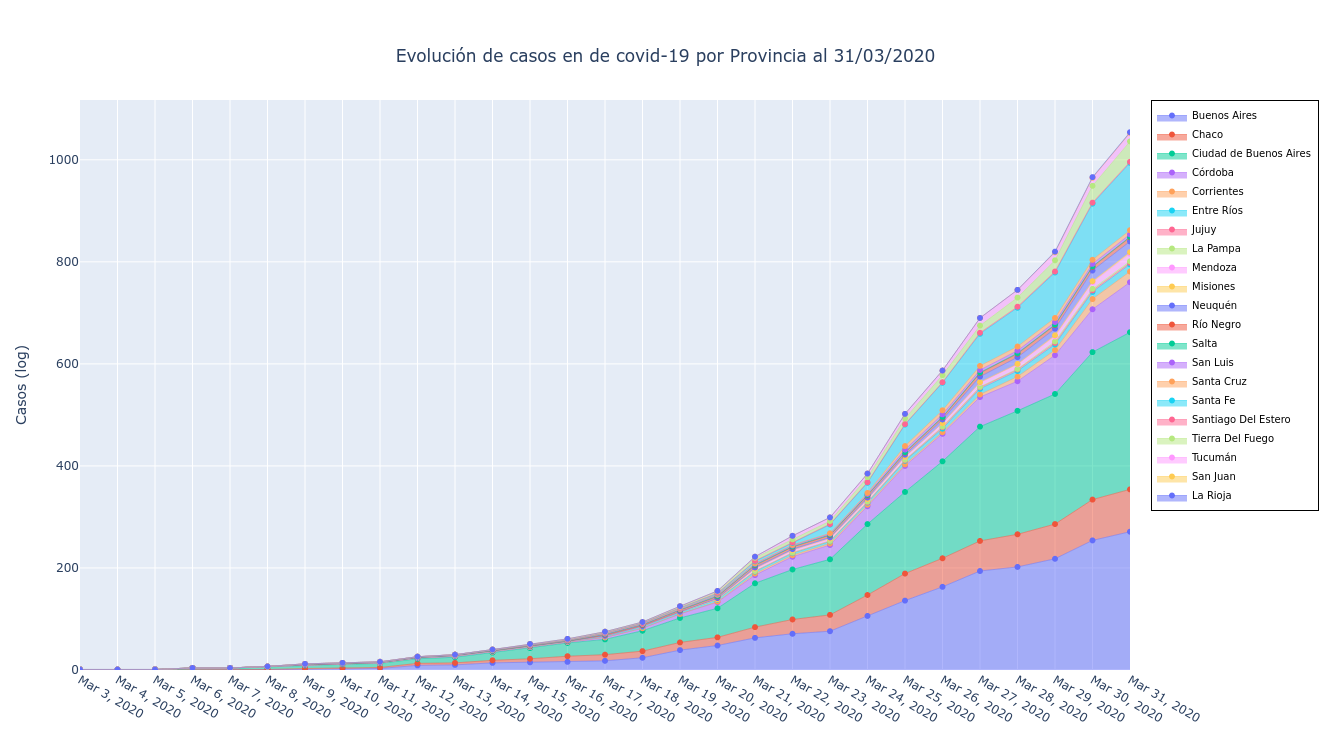

In [46]:
fig = go.Figure()
fechas = list(prov["fecha"].unique())
for provincia in lista_prov:
    ind = prov["provincia"] == provincia
    #x = list(range(1,len(ind)))    
    fig.add_trace(go.Scatter(x = prov.loc[ind,"fecha"], y=prov.loc[ind,"casos_acum"], text=provincia, mode='lines+markers',#x = x
                             line=dict(width=0.5),
                             stackgroup='one', # define stack group
                             name=provincia,))
    
#fig.add_trace(go.Scatter(x = prov.loc[ind,"fecha"], y=DPenazzi, text="Aprox DPenazzi", line=dict(width=2, dash='dash', color='royalblue'), name="Aprox. DPenazzi"))
#fig.add_trace(go.Scatter(x = total_diario["fecha"], y=total_diario["total"],  line=dict(width=2, color='red'), name="Diarios",mode='lines+markers',))

fig.update_layout(#yaxis_range=(0, 905), 
                  title_text='Evolución de casos en de covid-19 por Provincia al 31/03/2020', 
                  height=750, xaxis_title="Fecha", yaxis_title="Casos (log)",
                  #yaxis_type="log",
                xaxis_type="log",
                 )
fig.update_layout(
    legend=dict(
        #x=0.02,
        #y=1.15,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=10,
            color="black"
        ),
        #bgcolor="LightSteelBlue",
        bordercolor="Black",
        borderwidth=1,
        orientation="v",
    ),
    title={
        #'y':1.,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis=go.layout.XAxis(
        #ticktext=fechas,
        tickvals=fechas
    )
)
fig.show()

In [ ]:
fig.write_html("graphs/total_arg_provincias.html", include_plotlyjs="cdn", full_html=False)

Formatear fechas:

```
    fig.update_layout(
    ...
    xaxis=go.layout.XAxis(
        tickformat = '%d/%m'
    )
    )
    
    %a - abbreviated weekday name.*
    %A - full weekday name.*
    %b - abbreviated month name.*
    %B - full month name.*
    %c - the locale's date and time, such as %x, %X.*
    %d - zero-padded day of the month as a decimal number [01,31].
    %e - space-padded day of the month as a decimal number [ 1,31]; equivalent to %_d.
    %f - microseconds as a decimal number [000000, 999999].
    %H - hour (24-hour clock) as a decimal number [00,23].
    %I - hour (12-hour clock) as a decimal number [01,12].
    %j - day of the year as a decimal number [001,366].
    %m - month as a decimal number [01,12].
    %M - minute as a decimal number [00,59].
    %L - milliseconds as a decimal number [000, 999].
    %p - either AM or PM.*
    %Q - milliseconds since UNIX epoch.
    %s - seconds since UNIX epoch.
    %S - second as a decimal number [00,61].
    %u - Monday-based (ISO 8601) weekday as a decimal number [1,7].
    %U - Sunday-based week of the year as a decimal number [00,53].
    %V - ISO 8601 week of the year as a decimal number [01, 53].
    %w - Sunday-based weekday as a decimal number [0,6].
    %W - Monday-based week of the year as a decimal number [00,53].
    %x - the locale's date, such as %-m/%-d/%Y.*
    %X - the locale's time, such as %-I:%M:%S %p.*
    %y - year without century as a decimal number [00,99].
    %Y - year with century as a decimal number.
    %Z - time zone offset, such as -0700, -07:00, -07, or Z.
    %{n}f for fractional seconds with n digits. For example, 2016-10-13 09:15:23.456 with tickformat %H~%M~%S.%2f would display 09~15~23.46*
    %% - a literal percent sign (%).
```